# Example of runing the VGPA code on the Double-Well system

This notebook demonstrates a very simple case of the variational Gaussian process approximation (VGPA)
algorithm on the stochastically driven double-well (DW) dynamical system. More ...

In [1]:
# Just let the notebook plot all figures inside here ...
%matplotlib inline

## Imports
---
Before we begin, we import the top-level necessary packages. Moreover, we include the algorithm specific packages from the local directories.

In [3]:
# Get the system environment variables.
import sys

# General Imports:
import numpy as np
from time import time

# Variational:
from auxiliary.collect_obs import *
from auxiliary.initialize_Ab0 import *
from core.smoothing import *
from dynamics.sys_double_well import *

# Plotting:
from matplotlib.pyplot import figure, show, rcParams

# Change the default figure size.
rcParams['figure.figsize'] = (12.0, 6.0)

## Simulation Setup
---
Here we setup the simulation parameters for the example. We need to define the time-window along with the discretization time-step.

 >> Python version is: 3.5.1 |Anaconda 2.4.0 (x86_64)| (default, Dec  7 2015, 11:24:55) 
[GCC 4.2.1 (Apple Inc. build 5577)]

System tested: DW, T=[0,15]

 DW - trajectory

 [VGPA] (Smoothing) Experiment in progress. Please wait ...
 >> SCG optimization
 0:	fx=224.866	sum(gx)=370.872
 1:	fx=200.728	sum(gx)=222.763
 2:	fx=169.974	sum(gx)=164.867
 3:	fx=141.264	sum(gx)=128.677
 4:	fx=121.577	sum(gx)=95.918
 5:	fx=106.017	sum(gx)=102.729
 6:	fx=88.539	sum(gx)=60.829
 7:	fx=75.851	sum(gx)=72.272
 8:	fx=69.607	sum(gx)=38.850
 9:	fx=57.714	sum(gx)=39.011
 10:	fx=49.418	sum(gx)=32.087
 11:	fx=40.920	sum(gx)=46.342
 12:	fx=30.794	sum(gx)=58.675
 13:	fx=29.327	sum(gx)=21.482
 14:	fx=27.926	sum(gx)=9.687
 15:	fx=25.943	sum(gx)=12.906
 16:	fx=21.617	sum(gx)=15.556
 17:	fx=19.956	sum(gx)=10.755
 18:	fx=18.352	sum(gx)=8.497
 19:	fx=16.719	sum(gx)=10.131
 20:	fx=14.664	sum(gx)=11.848
 21:	fx=14.194	sum(gx)=6.298
 22:	fx=14.104	sum(gx)=2.792
 23:	fx=13.927	sum(gx)=2.229
 24:	fx=13.328	sum(gx)=3.451
 

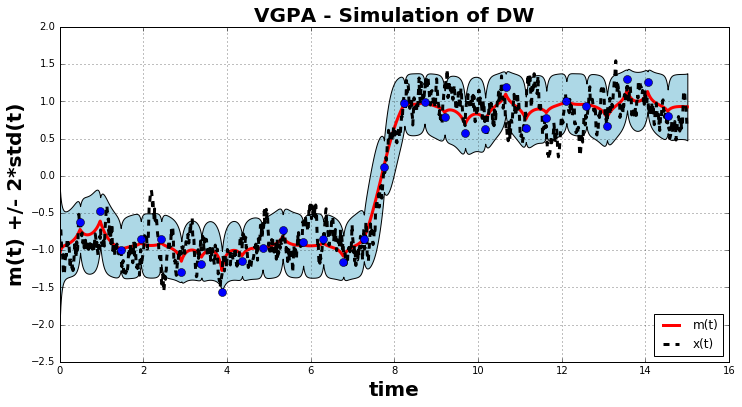

In [5]:
# Show current python version.
print(" >> Python version is: {0}\n".format(sys.version))

'''
TIME-WINDOW PARAMETERS:
'''

# Initial, final and time step.
t0 = 0; tf = 15; dt = 0.01

# Define the time-window of inference.
Tw = np.arange(t0, tf+dt, dt)

# Number of discretized points.
N = Tw.shape[0]

'''
SYSTEM SPECIFIC PARAMETERS:
'''

# Dimensionality of the system.
D = 1

# Stochastic Noise (variance).
sigma_Noise = 0.8

# Drift parameter.
theta_Drift = 1.0

# Observation Noise (variance).
obs_Noise = 0.04

# Print a message.
print("System tested: {0}, T=[{1},{2}]\n".format('DW',t0,tf))

'''
OBSERVATIONS SECTION:
'''

# Create the (artificial) true trajectory.
xt_true = system_path(Tw, sigma_Noise, theta_Drift)

# Define the observation density (# of observations per time unit).
n_Obs = 2

# We need at least one observation (per time unit)
n_Obs = np.max([n_Obs, 1])

# Sample the noisy observations from the true path.
obsX, obsY = collect_obs(xt_true, Tw, n_Obs, obs_Noise)

# Observation operator: np.eye(D)
H = 1.0

'''
PRIOR MOMEMTS:
'''

# Prior moment of initial condition noise variance.
# p(x0) ~ N(mu, tau0)
tau0 = 0.5

# Get the true sample value at time t=0
prior_x0 = {'mu0': xt_true[0,0], 'tau0': tau0}

# Initial mean m(t=0)
m0 = xt_true[0] + 0.1*np.random.randn(1)

# Initial covariance matrix S(t=0): K*np.eye(D)
S0 = 0.25

'''
PACKING PARAMETERS:
'''

# ODE solver: {'Euler', 'Heun', 'RK2', 'RK4'}
ode_method = 'Euler'

# Create a dictionary to hold all the model parameters.
sde_struct = {'Sig': sigma_Noise, 'theta': theta_Drift, 'Rig': obs_Noise,\
              'D': D, 'H': H, 'obsX': obsX, 'obsY': obsY, 'px0': prior_x0,\
              'Tw': Tw, 'dt': dt, 'N': N, 'ode_method': ode_method,\
              'checkGradf': False}

'''
INITIALIZATION:
'''

# Maximum number of iterations.
nit = 500

# Generate initial variational parameters (initial search point).
Ab0 = initialize_Ab0(S0, sde_struct)

# Main Operation.
print(' [VGPA] (Smoothing) Experiment in progress. Please wait ...')

# Start the timer.
tic = time()

# Full Variational approximation.
Fmin, mParam = smoothing(energy_mode, Ab0, m0, S0, sde_struct, nit)

# Stop the timer.
ttime = time() - tic

# Display termination message.
print(' [VGPA] (Smoothing) Experiment ended in {0:.2f} seconds.'.format(ttime))

# Display the minimum free energy.
print(' Minimum var. free energy is {0:.2f}.\n'.format(Fmin))

'''
PLOTTING SECTION:
'''

# Extract here the quantities for ploting.
mt = mParam['mt'] # marginal   mean   values.
St = mParam['St'] # marginal variance values.

# Create a new figure.
ax = figure().add_subplot(1,1,1)

# Prepare the error-bars.
upper_line = mt+2*np.sqrt(St)
lower_line = mt-2*np.sqrt(St)
ax.fill_between(Tw,\
                upper_line.flatten(),\
                lower_line.flatten(),\
                facecolor='lightblue')

# Add the mean path: m(t) and the true sample path: x(t).
ax.plot(Tw, mt,'r-',linewidth=3, label='m(t)')
ax.plot(Tw, xt_true,'k--',linewidth=3, label='x(t)')
ax.legend(loc='lower right')
ax.grid(True)

# Add the (noisy) observations.
obsX = (np.array(obsX)+1).tolist()
ax.plot(Tw[obsX], obsY, 'o', markersize=8)

# Setup the labels.
ax.set_ylabel('m(t) +/- 2*std(t)',\
              fontdict={'fontsize': 20, 'fontweight': 'bold'})
ax.set_xlabel('time',\
              fontdict={'fontsize': 20, 'fontweight': 'bold'})
ax.set_title('VGPA - Simulation of DW',\
             fontdict={'fontsize': 20, 'fontweight': 'bold'})

# Show-time.
show()

# End-Of-File